In [7]:
# Import libraries
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OrdinalEncoder, 
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale,
)

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from plot_classifier import plot_classifier

In [39]:
def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_accuracy": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_valid_accuracy": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_valid_score": "{:0.4f}".format(scores["test_score"].std()),
    }

# Lecture 5: More on categorical features and encoding text data

In [2]:
numeric_features = [
    "age",
    "fnlwgt",
    "education.num",
    "capital.gain",
    "capital.loss",
    "hours.per.week"
]

categorical_features = [
    "workclass",
    "education",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native.country"
]

target='income'

In [3]:
adult_df_large = pd.read_csv("data/adult.csv")

train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)

train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)

X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

## 1. More on categorical features

### 1). `make_pipeline` syntax and `handle_unknown`

In [4]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    
    # deal with the case where the validation set contains a category that doesn't exist in the training set.
    # all unknown categories will be represented with all zeros.
    OneHotEncoder(handle_unknown="ignore"), 
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipe = make_pipeline(preprocessor, SVC())


In [5]:
scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,13.888340,1.883801,0.859309,0.867502
1,11.812405,1.801952,0.846833,0.868509
2,11.506098,1.836123,0.863724,0.865342
3,11.759267,1.819544,0.851027,0.868132
4,13.014133,2.131569,0.856210,0.869476


### 2). Ordinal encoding

> When to use OrdinalEncoder

When there is actually an order in the values and it might help to encode this column using OrdinalEncoder.

In [6]:
train_df['education'].unique()

array(['HS-grad', 'Bachelors', 'Some-college', '11th', '5th-6th',
       'Assoc-voc', 'Masters', '9th', 'Doctorate', 'Prof-school',
       '7th-8th', '10th', '12th', '1st-4th', 'Assoc-acdm', 'Preschool'],
      dtype=object)

In [7]:
oe = OrdinalEncoder(dtype=int)
oe.fit(X_train[["education"]])
ed_transformed = oe.transform(X_train[["education"]])
ed_transformed = pd.DataFrame(data=ed_transformed, columns=["education_enc"], index=X_train.index)
ed_transformed.head()
oe.categories_[-1]

array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
       'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
       'Masters', 'Preschool', 'Prof-school', 'Some-college'],
      dtype=object)

In [8]:
# order is not good
pd.DataFrame(data=np.arange(len(oe.categories_[0])), columns=["transformed"], index=oe.categories_[0])

,transformed
10th,0
11th,1
12th,2
1st-4th,3
5th-6th,4
7th-8th,5
9th,6
Assoc-acdm,7
Assoc-voc,8
Bachelors,9


In [9]:
# order them manually.
education_levels = ['Preschool', '1st-4th', '5th-6th', '7th-8th', 
                    '9th', '10th', '11th', '12th', 'HS-grad',
                    'Prof-school', 'Assoc-voc', 'Assoc-acdm', 
                    'Some-college', 'Bachelors', 'Masters', 'Doctorate']


oe = OrdinalEncoder(categories=[education_levels], dtype=int)

oe.fit(X_train[["education"]])

ed_transformed = oe.transform(X_train[["education"]])

ed_transformed = pd.DataFrame(data=ed_transformed, columns=["education_enc"], index=X_train.index)

oe.categories_

[array(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
        '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-voc',
        'Assoc-acdm', 'Some-college', 'Bachelors', 'Masters', 'Doctorate'],
       dtype=object)]

In [10]:
numeric_features = ['age', 'fnlwgt', 'capital.gain', 
                    'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 
                        'relationship', 'race', 'sex', 'native.country']
ordinal_features = ['education']
target_column = 'income'

In [11]:
# numeric features
# ----------------
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

# categorical features
# --------------------
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

# ordinal features
# --------------------
ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int,),

)

# all preprocessors
# --------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ordinal", ordinal_transformer, ordinal_features)
    ]
)


# pipe
# --------------------------------------------------------------------------------
pipe = make_pipeline(preprocessor, SVC())

In [12]:
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores) #.mean()

,fit_time,score_time,test_score,train_score
0,12.893614,1.838780,0.850864,0.853201
1,10.757917,1.667393,0.844338,0.855744
2,11.294579,1.781004,0.860269,0.850513
3,10.919007,1.790021,0.849683,0.854120
4,11.087993,1.733486,0.854483,0.853160


### 3). Binary Feature

In [13]:
numeric_features = ['age', 'fnlwgt', 'capital.gain', 
                    'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 
                        'relationship', 'race', 'native.country']
ordinal_features = ['education']
binary_features = ['sex']
target_column = 'income'

In [14]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int,),

)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),    
    )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ordinal", ordinal_transformer, ordinal_features),
        ("binary", binary_transformer, binary_features)
    ]
)
pipe = make_pipeline(preprocessor, SVC())

In [11]:
X = [['Male', 1], ['Female', 3], ['Female', 2]]

In [13]:
ohe = OneHotEncoder(handle_unknown="ignore")

ohe.fit_transform(X).toarray()




array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.]])

In [16]:
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,11.347639,1.772806,0.850864,0.853153
1,10.595717,1.723772,0.844530,0.855792
2,10.441267,1.666646,0.859693,0.850609
3,10.966699,1.699913,0.849299,0.853832
4,10.831024,1.769650,0.854291,0.853448


## 2. Encoding text data - BOW

### 1). `CountVectorizer`
- Converts a collection of text documents to a matrix of word counts.  
- Each row represents a "document" (e.g., a text message in our example). 
- Each column represents a word in the vocabulary in the training data. 
- Each cell represents how often the word occurs in the document. 

#### Why sparse matrices?
- Most words do not appear in a given document.    
- We get massive computational savings if we only store the nonzero elements.    
- There is a bit of overhead, because we also need to store the locations:    
- e.g. "location (3,31): 1".
- However, if the fraction of nonzero is small, this is a huge win.         
- What would happen if you apply  `StandardScaler`  on sparse data?    
    > [Centering sparse data would destroy the sparseness structure in the data](https://scikit-learn.org/stable/modules/preprocessing.html)    
    > I would say that applying StandardScaler  on sparse data, especially on encoding created by `CountVectorizer`, is usually not a good idea. As you said, it'll become a dense matrix if we do it. If your vocabulary is ~75,000, similar to what you had in the IMDB data, your matrix will be of shape (75000, 75000)! I haven't seen people applying scaling on sparse data.
        
#### `OneHotEncoder` and sparse features 
- By default, `OneHotEncoder` also creates sparse features. 
- You could set `sparse=False` to get a regular `numpy` array. 
- If there are a huge number of categories, it may be beneficial to keep them sparse.
- For smaller number of categories, it doesn't matter much.


#### Important hyperparameters of `CountVectorizer` 
- `binary`
    - whether to use absence/presence feature values or counts
- `max_features`
    - only consider top `max_features` ordered by frequency in the corpus
- `max_df`
    - ignore features which occur in more than `max_df` documents 
- `min_df` 
    - ignore features which occur in less than `min_df` documents 
- `ngram_range`
    - consider word sequences in the given range 
    
    

In [19]:
X = [
    "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
    "Lol you are always so convincing.",
    "Nah I don't think he goes to usf, he lives around here though",
    "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
    "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030",
    "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
]

y = ["spam", "non spam", "non spam", "spam", "spam", "non spam"]

### 2). Default hyperparameters

In [20]:
vec = CountVectorizer()

X_counts = vec.fit_transform(X) # sparse matrix

bow_df = pd.DataFrame(X_counts.toarray(), columns=sorted(vec.vocabulary_), index=X)

bow_df

,08002986030,100000,11,900,all,always,are,around,as,been,...,update,urgent,usf,valued,vettam,week,with,won,you,your
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,0,1,0,0,0,0,1,1,...,0,1,0,1,0,0,0,0,1,0
Lol you are always so convincing.,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,0,1,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,1
As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,0,0,0,0,1,0,0,0,2,1,...,0,0,0,0,1,0,0,0,0,3


In [18]:
print("The total number of elements: ", np.prod(X_counts.shape))
print("The number of non-zero elements: ", X_counts.nnz)
print(
    "Proportion of non-zero elements: %0.4f" % (X_counts.nnz / np.prod(X_counts.shape))
)
print("The value at cell 3,%d is: %d" % (vec.vocabulary_["jackpot"], X_counts[3, vec.vocabulary_["jackpot"]]))

The total number of elements:  432
The number of non-zero elements:  85
Proportion of non-zero elements: 0.1968
The value at cell 3,31 is: 1


### 3). `binary=True, max_features=8`

In [25]:
# We can control the size of X (the number of features) using `max_features`
vec8 = CountVectorizer(binary=True, max_features=8)

X_counts = vec8.fit_transform(X)

pd.DataFrame(data = X_counts.sum(axis=0).tolist()[0], 
             index = vec8.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)

bow_df = pd.DataFrame(X_counts.toarray(), columns=sorted(vec8.vocabulary_), index=X)
bow_df

,as,been,free,have,prize,to,you,your
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,1,1,0,1,1,1,1,0
Lol you are always so convincing.,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,1,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,0,1,1,1,0,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,0,0,1,0,0,1,0,1
As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,1,1,0,0,0,1,0,1


## 3. Questions

#### 1) `handle_unknown="ignore"` would treat all unknown categories equally.

> True 

When this parameter is set to ‘ignore’ and an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros.
#### 2) Creating groups of rarely occurring categories might overfit the model.
> False.    

Creating groups of rarely occurring categories would help with generalization. Rare categories would be put in appropriate groups and you would have enough data to learn meaningful patterns for each group.


#### 3) `CountVectorizer`: True or False

#### As you increase the value for `max_features` hyperparameter of `CountVectorizer` the training score is likely to go up. 
> Varada's answer: True because increasing the value of `max_features` means we include each and every word from the training data in the dictionary and the training score is likely to go up. 
#### If we encounter a word in the validation or the test split that's not available in the training data, we'll get an error. 
> Varada's answer: False because if the word isn't in the dictionary, we would just ignore the word. 
#### `max_df` hyperparameter of `CountVectorizer` can be used to get rid of most frequently occurring words from the dictionary.    
> True because words such as _a_, _the_, _in_, _of_ occur in most of the documents, and with `max_df` hyperparameter, we can control the features to be used based on the number of documents they occur in. So if we set this to a higher proportion, we can get rid of such stop words.    

# Lecture 6: Hyperparameter optimization and optimization bias

In [30]:
# numeric features
# ----------------
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

# categorical features
# --------------------
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

# ordinal features
# --------------------
ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int,),

)

# all preprocessors
# --------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ordinal", ordinal_transformer, ordinal_features)
    ]
)


# pipe
# --------------------------------------------------------------------------------
pipe = make_pipeline(preprocessor, SVC())

## 1. `GridSearchCV`

### What?
> Exhaustive search over specified parameter values for an estimator.



### Problems with exhaustive grid search 

- Required number of models to evaluate grows exponentially with the dimensionally of the configuration space. 
- Example: Suppose you have
    - 5 hyperparameters 
    - 10 different values for each hyperparameter
    - You'll be evaluating $10^5=100,000$ models! That is you'll be calling `cross_validate` 100,000 times!
- Exhaustive search may become infeasible fairly quickly. 
- Other options? 

In [32]:
param_grid = {
    "svc__gamma": [0.1, 1.0],
    "svc__C": [0.1, 1.0],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train);

In [33]:
print("Best cv score from grid search: %.3f" % grid_search.best_score_)
grid_search.best_params_

Best cv score from grid search: 0.856


{'svc__C': 1.0, 'svc__gamma': 0.1}

In [34]:
pd.DataFrame(grid_search.cv_results_).set_index("rank_test_score").sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,...,split4_test_score,mean_test_score,std_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,28.464113,0.792866,3.498721,0.082208,1,0.1,"{'svc__C': 1.0, 'svc__gamma': 0.1}",0.857965,0.848369,0.865067,...,0.857362,0.856380,0.005543,0.870141,0.872061,0.867454,0.869523,0.869859,0.869808,0.001470
2,29.135489,0.185586,3.744439,0.012246,0.1,0.1,"{'svc__C': 0.1, 'svc__gamma': 0.1}",0.850096,0.843186,0.854894,...,0.853907,0.849893,0.004300,0.853825,0.854449,0.851329,0.853688,0.852488,0.853156,0.001112
3,127.062997,12.207516,5.367153,1.302088,1,1,"{'svc__C': 1.0, 'svc__gamma': 1.0}",0.816123,0.814012,0.815355,...,0.812056,0.814458,0.001388,0.939821,0.941597,0.940637,0.942560,0.941552,0.941233,0.000932
4,158.147294,13.014553,8.150106,0.091010,0.1,1,"{'svc__C': 0.1, 'svc__gamma': 1.0}",0.775624,0.776775,0.775240,...,0.774621,0.776605,0.002195,0.782417,0.781217,0.780545,0.781611,0.782523,0.781663,0.000743


## 2. The `__` syntax 

- Above: we have a nesting of transformers.
- We can access the parameters of the "inner" objects by using __ to go "deeper":
- `svc__gamma`: the `gamma` of the `svc` of the pipeline
- `svc__C`: the `C` of the `svc` of the pipeline

For example:
> `columntransformer__num__simpleimputer__strategy` 

the strategy used with `SimpleImputer` of the preprocessor in the pipeline. 
Later in the course we'll see even deeper nesting, like preprocessor__numeric__imputer__strategy.

In [4]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(CountVectorizer(), LogisticRegression())

In [6]:
pipe

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression())])

In [21]:
param_grid = {
    "countvectorizer__binary": [True, False],
    "countvectorizer__max_features": [100, 1000, 10_000, 50_000],
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

In [ ]:
param_grid = {
    "svc__gamma": [0.1, 1.0],
    "columntransformer__num__simpleimputer__strategy": ['mean', 'median'],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True);
grid_search.fit(X_train, y_train);

In [ ]:
print(("Best SVC from grid search: %.3f" % grid_search.score(X_test, y_test)))
grid_search.best_params_
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

In [ ]:
pd.DataFrame(grid_search.cv_results_)[
    [
        "mean_test_score",
        "param_columntransformer__num__simpleimputer__strategy",
        "param_svc__gamma",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

## 3. `RandomizedSearchCV`

### What?
> - In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by `n_iter`.
> - If **all parameters are presented as a list**, sampling without replacement is performed. If **at least one parameter is given as a distribution**, sampling with replacement is used. It is highly recommended to use continuous distributions for continuous parameters.
### Advantages of `RandomizedSearchCV`

- Faster compared to `GridSearchCV`.
- Adding parameters that do not influence the performance does not affect efficiency.
- In general, I recommend using `RandomizedSearchCV` rather than `GridSearchCV`.  

In [ ]:
param_grid = {
    "svc__gamma": 10.0 ** np.arange(-6, 6),
    "svc__C": 10.0 ** np.arange(-6, 6)
}
print("Grid size: %d" %(np.prod(list(map(len, param_grid.values())))))
param_grid

random_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=5);
random_search.fit(X_train, y_train);

In [ ]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

## 4. Optimization bias

>  Overfitting of the validation data

### 1). Overfitting of the validation data

<center>
<img src='img/bias2.png' width="800">
</center>


[Source](https://amueller.github.io/COMS4995-s20/slides/aml-03-supervised-learning/#20)
### 2). Overfitting of the validation error 

- Why do we need to evaluate the model on the test set in the end?
- Why not just use cross-validation on the whole dataset? 
- While carrying out hyperparameter optimization, we end up trying over many possibilities.  
- If our dataset is small and if your validation set is hit too many times, we suffer from **optimization bias** or **overfitting the validation set**. 


### 3). Optimization bias of parameter learning:
- During learning, we could search over tons of different decision trees.
- So we can get "lucky" and find one with low training error by chance.
    - "Overfitting of the training error".
    
### 4). Optimization bias of hyper-parameter learning:
- Here, we might optimize the validation error over 100 values of `max_depth`.
- One of the 100 trees might have low validation error by chance.

## 5. Questions

---
## 1). `GridSearchCV` VS `RandomizedSearchCV`

### Questions for class discussion (hyperparameter optimization)

- Suppose you have 10 hyperparameters, each with 4 possible values. If you run `GridSearchCV` with this parameter grid, how many cross-validation experiments it would carry out? 
> $4^{10}$


- `GridSearchCV` exhaustively searches the grid and so it's guaranteed to give you the optimal hyperparameters for the given problem. 
> False, it only exhaustively searches over specified parameter values for an estimator. These values might not contain the optimal hyperparameters for the given problem.  

- It is possible to get different hyperparameters in different runs of `RandomizedSearchCV`.
> True (unless a random seed is provided).


- Suppose you have 10 hyperparameters and each takes 4 values. If you run `RandomizedSearchCV` with this parameter grid, how many cross-validation experiments it would carry out? 
> By default, only 10 experiments are carried out. Because the number of parameter settings that are tried is given by `n_iter` and `n_iter=10` by default.

- Give one advantage of using RandomizedSearchCV over GridSearchCV.
>Solution Any of the following works.
    - RandomizedSearchCV is faster compared to GridSearchCV because we can control the number of iterations.
    - RandomizedSearchCV is a better choice when some parameters are more important than others; adding parameters that do not influence the performance does not affect efficiency.
    - By passing probability distributions to RandomizedSearchCV, we can explore different parts of the search space.
    - The search space is huge and it's infeasible to search all possibilities exhaustively. In random search we can provide some guidance for the search by passing our `param_grid` to param_distributions, where you can either provide **discrete values** as we did it in the lecture or **probability distributions**. It can then generate n_iter random hyperparameter configurations from the provided grid.


---
## 2). Optimization Bias

### Principles
> if training dataset is small and so our validation splits in cross validation would be small.
- the best validation score is not good estimate of test score.
- the best hyperparameter set is not the best globally because of the small dataset and the fact that we hit the small validation set 900 times and it's possible that we got lucky on the validation set! 
- but we can trust the test score on the test data if the test dataset is huge.

### Large datasets solves many of these problems
- With infinite amounts of training data, overfitting would not be a problem and you could have your test score = your train score.
    - Overfitting happens because you only see a bit of data and you learn patterns that are overly specific to your sample.
    - If you saw "all" the data, then the notion of "overly specific" would not apply.
- So, more data will make your test score better and robust. 
- What to do if your test score is much lower than your cross-validation score:
    - Try simpler models and use the test set a couple of times - it's not the end of the world.
    - Communicate this clearly when you report the results. 
    
![](img/bias.png) 

# Lecture 7: Naive Bayes

In [36]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [37]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


## 1. `MultinomialNB`

> `MultinomialNB`    
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.



> `BernoulliNB`    
Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for **binary/boolean features**.



In [43]:
results_dict = {}

# sklearn naive Bayes classifier
pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB())
scores = cross_validate(pipe_nb, X_train, y_train, return_train_score=True)
store_cross_val_results('Naive Bayes', scores, results_dict)

# SVC classifier for spam detection
pipe_svc= make_pipeline(CountVectorizer(), SVC())
scores = cross_validate(pipe_svc, X_train, y_train, return_train_score=True)
store_cross_val_results('SVC', scores, results_dict)

In [44]:
pd.DataFrame(results_dict).T

,mean_train_accuracy,mean_valid_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_valid_score
Naive Bayes,0.9935,0.9859,0.0645,0.0122,0.0007,0.0026
SVC,0.9950,0.9785,0.7431,0.1709,0.0005,0.0048


#### 1). predict

In [45]:
pipe_nb.fit(X_train, y_train)
deploy_test = ["URGENT! Free!!", "Let's enjoy the last week of block 2!"]
pipe_nb.predict(deploy_test)

array(['spam', 'ham'], dtype='<U4')

> **Summary naive Bayes `predict`**

- Estimate the following probabilities using naive Bayes' assumption. 

**Spam**
$$ P(\text{spam} \mid \text{message}) \propto P(\text{spam}) \times  \prod_{i=1}^{d}P(w_i \mid \text{spam})$$

Example:
$$\begin{equation}
\begin{split}
P(\text{spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \\
& \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto 3/3 \times 2/3 \times 1/3 \times 2/3 \times 3/6\\
\end{split}
\end{equation}$$

---

**Non-Spam**
$$ P(\text{non spam} \mid \text{message}) \propto P(\text{non spam}) \times  \prod_{i=1}^{d}P(w_i \mid \text{non spam})$$

Example:
$$\begin{equation}
\begin{split}
P(\text{non spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{non spam}) \times P(\text{non spam})\\
&\propto P(\text{block} = 0 \mid \text{non spam}) \times P(\text{free} = 1 \mid \text{non spam}) \\
& \times P(\text{prize} = 0 \mid \text{non spam}) \times P(\text{urgent} = 1 \mid \text{non spam}) \times P(\text{non spam})\\
&\propto 1/3 \times 0 \times 3/3 \times 0 \times 1/3\\
\end{split}
\end{equation}$$


#### 2). `predict_proba`

- `predict` returns the class with the highest probability.
- `predict_proba` gives us the actual probability scores. 


---
> Although decision tree, kNN, and RBF SVM are not set in a probabilistic framework, they still have `predict_proba` method to get the probability estimates.  

- [`DecisionTreeClasifier.predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)
  - Computed as fraction of that class in leaf node.
- [`KNeighborsClassifier.predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba)
  - Computed as fraction of that class in $k$ neighbours.
- [`MultinomialNB.predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.predict_proba)
  - Already computed, just need to normalize them (so they sum to 1).
  
 
 
 ---
> - Recall that when we worked through a toy example by hand, we estimated
    - $P(\text{non spam} \mid \text{message}) \propto 0$
    - $P(\text{spam} \mid \text{message}) \propto 0.074$
   

- Why don't `predict_proba` scores match with the probability scores we calculated before? 
- The scores we computed are not normalized. Remember that we ignored the denominator.
- These ones are normalized so that they sum to 1.
- The model is using something called "smoothing" to avoid the problem of zero probabilities. 

In [50]:
pipe_nb.classes_

array(['ham', 'spam'], dtype='<U4')

In [48]:
pipe_nb.predict_proba(deploy_test)

array([[0.03344968, 0.96655032],
       [0.96741982, 0.03258018]])

In [49]:
pipe_nb.predict_proba(["URGENT! Free!!"])

array([[0.03344968, 0.96655032]])

#### 3). Laplace smoothing

#### **Motivation**

- Remember when we calculated $P(\text{non spam} \mid \text{message})$, some of our conditional probabilities were zero. 
    - $P(\text{free} = 1 \mid \text{non spam}) = 0/3$ 
    - $P(\text{urgent} = 1 \mid \text{non spam}) = 0$
- Naive Bayes naively multiplies all the feature likelihoods together, and if any of the terms is zero, it's going to void all other evidence and the probability of the class is going to be zero.
    
    
#### **A simplest solution: Laplace smoothing**

- The simplest way to avoid zero probabilities is to add one to all the counts.
- All the counts that used to be zero will now have a count of 1, the counts of 1 will be 2, and so on. 
- In `scikit-learn` we control it using hyperparameter `alpha` (by default `alpha=1.0`). 

$$P(\text{word} \mid \text{spam}) = \frac{Count(\text{word}, \text{spam}) + 1}{\sum_{w \in vocabulary} Count(w, \text{spam}) + |vocabulary|}$$

In [51]:
pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB(alpha=1.0))
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [52]:
results_dict = {"alpha": [], "mean_train_score": [], "mean_cv_score": [], "std_cv_score" : [], "std_train_score":[]}
param_grid = {"alpha": 10.0**np.arange(-6,4)}

for alpha in param_grid["alpha"]:
    pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB(alpha = alpha))
    scores = cross_validate(pipe_nb, X_train[:200], y_train[:200], return_train_score=True)
    results_dict["alpha"].append(alpha)
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)
results_df

,alpha,mean_train_score,mean_cv_score,std_cv_score,std_train_score
0,0.000001,1.00000,0.945,0.040000,0.000000
1,0.000010,1.00000,0.950,0.044721,0.000000
2,0.000100,1.00000,0.955,0.036742,0.000000
3,0.001000,1.00000,0.955,0.036742,0.000000
4,0.010000,1.00000,0.955,0.036742,0.000000
5,0.100000,0.99875,0.950,0.035355,0.002500
6,1.000000,0.99500,0.960,0.040620,0.002500
7,10.000000,0.93625,0.870,0.010000,0.009186
8,100.000000,0.87000,0.870,0.010000,0.002500
9,1000.000000,0.87000,0.870,0.010000,0.002500


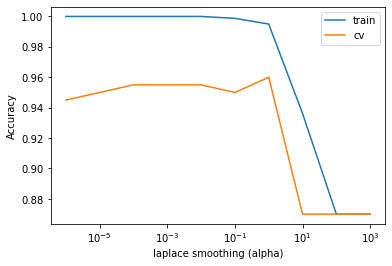

In [53]:
plt.semilogx(param_grid["alpha"],results_dict["mean_train_score"],label="train");
plt.semilogx(param_grid["alpha"],results_dict["mean_cv_score"],label="cv");
plt.legend();
plt.xlabel('laplace smoothing (alpha)');
plt.ylabel('Accuracy');

## 2. `GaussianNB`
#### We can use Gaussian Naive Bayes if you have continuous features. 
- Assume each feature is normally distributed 
- Calculate the mean ($\mu_k$) and standard deviation ($\sigma_k$) for each feature for each class
- Use the following equation to calculate the conditional probability of observing feature value $v$ in class $C_k$

<img src='./img/gau.png' width="400">


In [55]:
df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 123) # 80%-20% train test split on df
X_train, y_train = train_df.drop(columns=["country"]), train_df["country"] 
X_test, y_test = test_df.drop(columns=["country"]), test_df["country"]
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


> `PowerTransformer()` transform our data to try and make it more normal

In [57]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
X_train[['longitude', 'latitude']] = pt.fit_transform(X_train)

Text(0.5, 1.0, 'Naive Bayes decision boundary')

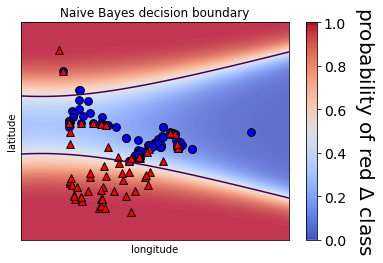

In [62]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

plt.figure()
ax = plt.gca()
plot_classifier(X_train, y_train, model, ax=ax, proba=True);

plt.ylabel("latitude");
plt.xlabel("longitude");
plt.title("Naive Bayes decision boundary")

- Predictions in darker colours: the model is more confident
- Predictions in lighter colours: the model is less confident

## 3. Naive Bayes on multi-class problems



In [64]:
from sklearn import datasets
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'))
X_news_train, y_news_train = newsgroups_train.data, newsgroups_train.target
X_news_test, y_news_test = newsgroups_test.data, newsgroups_test.target

newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

> Let's try `DummyClassifier`

In [65]:
pipe_multi = make_pipeline(CountVectorizer(), DummyClassifier(strategy="most_frequent"))
scores = cross_validate(pipe_multi, X_news_train, y_news_train, return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,1.570517,0.312785,0.053027,0.053033
1,1.439163,0.323488,0.053027,0.053033
2,1.431487,0.298612,0.053027,0.053033
3,1.531262,0.300876,0.053027,0.053033
4,1.409572,0.287315,0.053050,0.053027


> Let's try `MultinomialNB`

In [66]:
pipe_multi = make_pipeline(CountVectorizer(), MultinomialNB())
scores = cross_validate(pipe_multi, X_news_train, y_news_train, return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,1.546523,0.329521,0.583738,0.741465
1,1.350987,0.324121,0.570040,0.739587
2,1.319769,0.271244,0.583297,0.749309
3,1.374500,0.274554,0.571365,0.731963
4,1.463406,0.259852,0.588859,0.739063


In [69]:
# fit and predict
pipe_multi.fit(X_news_train, y_news_train); 

prediction = pipe_multi.predict([X_news_test[100]])[0]

In [70]:
print(X_news_test[100])
prediction = pipe_multi.predict([X_news_test[100]])[0]
print('Prediction index: %d and prediction class: %s' %(prediction, newsgroups_train.target_names[prediction]))

Hello All!

    It is my understanding that all True-Type fonts in Windows are loaded in
prior to starting Windows - this makes getting into Windows quite slow if you
have hundreds of them as I do.  First off, am I correct in this thinking -
secondly, if that is the case - can you get Windows to ignore them on boot and
maybe make something like a PIF file to load them only when you enter the
applications that need fonts?  Any ideas?


Chris
Prediction index: 5 and prediction class: comp.windows.x


In [71]:
pipe_multi.predict_proba([X_news_test[100]])

array([[7.26904475e-19, 1.48743104e-10, 4.16538604e-28, 2.96340768e-10,
        1.91391647e-14, 1.00000000e+00, 4.34194388e-28, 2.40916532e-18,
        9.74009600e-22, 1.72603033e-31, 5.61184330e-31, 8.76853929e-14,
        1.00705690e-16, 2.70331089e-13, 2.36762710e-21, 5.91222397e-16,
        3.61589511e-15, 1.49715839e-13, 2.92789387e-16, 1.20413840e-24]])

## 4. Questions

#### 1. Laplace smoothing helps us deal with unknown words, the words that do not occur in the vocabulary of the training set. 

Varada's answer: False

#### 2. Naive Bayes should only be used if the "naive" conditional independence assumption holds for your problem.

Varada's answer: leaning towards False (you can still use it, but you should be careful about it.)

#### 3. Naive Bayes should only be used when the features (i.e. `X`-values) are binary.

Varada's answer: False.

#### 4. What goes wrong in naive Bayes when Laplace smoothing is not used?

If any of the conditional probabilities is zero because the feature value does not occur with the target in the training data, the probability estimate of the class would be zero. This happens because naive Bayes naively multiplies all the feature likelihoods together. It's going to void all other evidence and the probability of the class is going to be zero.


#### 5. When we ignore the marginal probability P(message) when calculating $P(\text{spam} | \text{message})$ or $P(\text{non spam} | \text{message})$, are these going to be well-defined probabilites? Does it matter?  
> Not well-defined probabilites. But it doesn't matter.

Naive Bayes estimates probability scores with two simplifying assumptions.
- It ignores the denominator (P(message) in our example) when calculating the probability.
- It assumes conditional independence among features given the target.

For more details, search for "Naive Bayes' approximation to calculate" in the lecture 7 notes.

So the estimates we get are not real probabilities. They are good enough for classification, i.e., making hard decisions (e.g., spam vs non-spam) but the scores are not truly representative of the uncertainty we have in a certain prediction due to our simplifying assumptions.


#### 6. Can we discuss how Naive Bayes is a decent classifier but a bad estimator? Furthermore, why are we then even looking at predict_proba if it is not good? Is it just the order of values we care about, not the values themselves?


It's a descent classifier in the sense that it tends to assign a lower probability score for less likely class and higher score for a likely class, and so it's able to distinguish between classes. That said, the probability scores it calculates in the process are not very reliable because we ignore the denominator when calculating the scores and so they are not well-defined probabilities.

# Lecture 8: Linear models and multi-class, meta-strategies

- Learn coefficients (weights) associated with features
<center>
<img src='./img/words_coeff.png' width="300" height="300" />
</center>


A linear classifier is a linear function of $X$ followed by a threshold. 

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots + w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

$$\hat{y} = \begin{cases}
         1, & \text{if } z \geq r\\
         -1, & \text{if } z < r
\end{cases}$$

Components of a linear classifier:
1. input features ($x_1, \dots, x_d$) e.g. Feature vector for $x_i$: [1, 0, 1, 1, 0, 0, 0]    
2. coefficients (weights) ($w_1, \dots, w_d$)
3. bias ($b$ or $w_0$) (can be used to offset your hyperplane)
4. threshold ($r$)

In our example, we assumed $r=0$ and $b=0$.


## In linear models:
 
- the $j$th coefficient tells us how feature $j$ affects the prediction
- if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$
- if $w_j < 0$ then increasing $x_{ij}$ moves us toward prediction $-1$
- if $w_j == 0$ then the feature is not used in making a prediction

## 1. `LogisticRegression`

Logistic regression

- A linear model for classification. 
- It learns **weights** associated with each feature and the **bias**. 
- The decision boundary is a **hyperplane dividing** the feature space in half. That's why we call it a linear classifier.
- You can think of the **coefficients as controlling the orientation/tilt of the hyperplane** and **the bias representing the intercept** (offset from the origin). (More on this in 573.)

- More on how it learns weights and bias in 573 and 572.
- In this course we will focus on the following aspects of logistic regression.  
    - `predict`, `predict_proba` 
    - how to use `coef_` to interpret the model

In [7]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

In [8]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()
scores = cross_validate(lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.013254,0.001968,0.852941,0.827068
1,0.010143,0.001831,0.823529,0.827068
2,0.008317,0.001724,0.696970,0.858209
3,0.008096,0.001448,0.787879,0.843284
4,0.007385,0.001978,0.939394,0.805970


In [77]:
lr.fit(X_train, y_train);

> decision boundary

Notice a linear decision boundary (a line in our case).
Compare it with Naive Bayes, KNN, or SVM RBF decision boundaries.

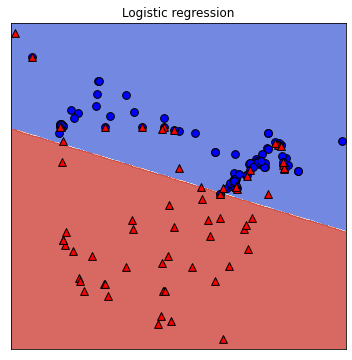

In [78]:
plt.figure(figsize=(6, 6))
plot_classifier(X_train, y_train, lr, ax=plt.gca())
plt.title("Logistic regression");

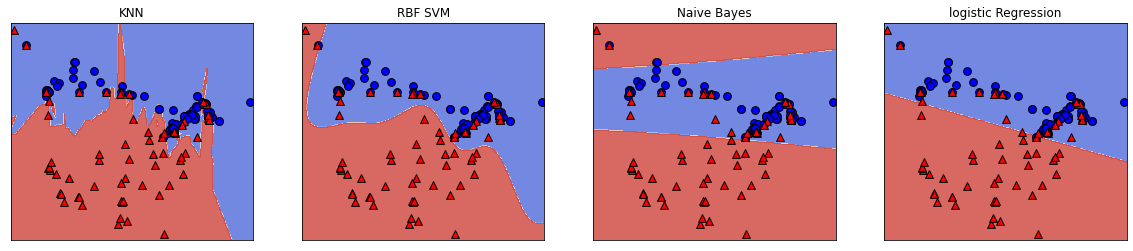

In [79]:
models = {
    "KNN": KNeighborsClassifier(),    
    "RBF SVM": SVC(gamma = 0.01),    
    "Naive Bayes": GaussianNB(),    
    "logistic Regression": LogisticRegression()
}

plt.figure(figsize=(20, 4))
i = 0
for name, model in models.items():    
    plt.subplot(1, 4, i + 1)
    model.fit(X_train, y_train)
    plot_classifier(X_train, y_train, model, ax=plt.gca())
    plt.title(name);
    i += 1

#### 1) `coef_` and `intercept_`

> `coef_`: Accessing learned weights
> `intercept_`: Accessing intercepts

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

In [9]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s"%(lr.coef_)) # these are weights
print("Model intercept: %s"%(lr.intercept_)) # this is the bias term

data = {'features': X_train.columns, 'coefficients':lr.coef_[0]}
pd.DataFrame(data)

Model weights: [[-0.04108149 -0.33683126]]
Model intercept: [10.8869838]


,features,coefficients
0,longitude,-0.041081
1,latitude,-0.336831


#### 2) Prediction with learned weights

Calculate $\hat{y}$ as: ```y_hat = np.dot(w, x) + b```

In [10]:
example = X_test.iloc[0,:]

np.dot(example.tolist(), lr.coef_.flatten()) + (lr.intercept_)

array([-1.97817876])

In [11]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- Our threshold here is 0
- The sign is `value>0 == false` and so predict class 0 (Canada in our case). 

In [12]:
lr.predict([example])

array(['Canada'], dtype=object)

#### 3) sigmoid function

Scores to probabilities

> sigmoid function: "squashes" the raw model output from any number to the range $[0,1]$.    
> convert values from $(-\infty, +\infty)$ to $[0, 1]$


#### "soft predictions", aka predicted probabilities. 
  - To convert the raw model output into probabilities, instead of taking the sign, we apply the sigmoid.
  
$$\frac{1}{1+e^{-x}}$$   
  
  
<center>
<img src='./img/sig.png' width="300" height="300" />
</center>

Features with positive coefficients increase the probability of the modeled outcome as they increase, while features with negative coefficients decrease the probability as they increase.

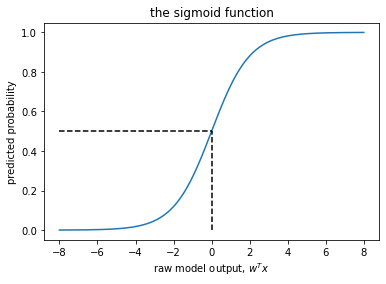

In [13]:
sigmoid = lambda x: 1/(1+np.exp(-x))
raw_model_output = np.linspace(-8,8,1000)
plt.plot(raw_model_output, sigmoid(raw_model_output));
plt.plot([0,0],[0,0.5], '--k')
plt.plot([-8,0],[0.5,0.5], '--k')
plt.xlabel("raw model output, $w^Tx$"); plt.ylabel("predicted probability");plt.title("the sigmoid function");

#### 4) `predict_proba`

In [100]:
lr.predict_proba([example])

array([[0.87848688, 0.12151312]])

In [102]:
# Predicting probabilities
data_dict = {"y":y_train[:10], 
             "predicted y": lr.predict(X_train[:10]).tolist(),
             "probabilities": lr.predict_proba(X_train[:10]).tolist()}
pd.DataFrame(data_dict)

,y,predicted y,probabilities
160,Canada,Canada,"[0.7046068097086481, 0.2953931902913519]"
127,Canada,Canada,"[0.5630169062040135, 0.43698309379598654]"
169,Canada,Canada,"[0.8389680973255864, 0.16103190267441364]"
188,Canada,Canada,"[0.7964150775404333, 0.20358492245956678]"
187,Canada,Canada,"[0.9010806652340972, 0.0989193347659027]"
192,Canada,Canada,"[0.7753006388010791, 0.2246993611989209]"
62,USA,USA,"[0.030740704606528002, 0.969259295393472]"
141,Canada,Canada,"[0.6880304799160921, 0.3119695200839079]"
183,Canada,Canada,"[0.7891358587234145, 0.21086414127658554]"
37,USA,USA,"[0.006546969753885579, 0.9934530302461144]"


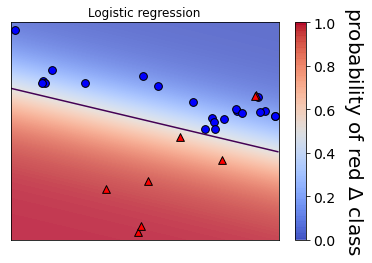

In [105]:
plot_classifier(X_train[:30], y_train[:30], lr, proba=True, ax=plt.gca())
plt.title("Logistic regression");

#### 5) Example

Spam filter

In [16]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head() 

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


> `fit` and `predict` using `LogisticRegression`

In [14]:
pipe_lr = make_pipeline(CountVectorizer(stop_words='english'), 
                        LogisticRegression()) # pipeline with logistic regression

In [15]:
results = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(results)

/Users/frank/opt/anaconda3/envs/571/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/571/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/frank/opt/anaconda3/envs/571/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/frank/opt/anaconda3/envs/571/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1344, in fit
    accept_large_sparse=solver != 'liblinear')
  File "/Users/frank/opt/anaconda3/envs/571/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/frank/opt/anaco

,fit_time,score_time,test_score,train_score
0,0.003072,0.0,NaN,NaN
1,0.001938,0.0,NaN,NaN
2,0.001795,0.0,NaN,NaN
3,0.001736,0.0,NaN,NaN
4,0.001644,0.0,NaN,NaN


> Finding examples where the model is most confident 


In [17]:
pipe_lr.fit(X_train, y_train);

In [20]:
pipe_lr.predict_proba(X_train)[:, 1]

array([0.01243484, 0.00178253, 0.00823734, ..., 0.01078384, 0.01499091,
       0.00752707])

In [18]:
spam_probs = pipe_lr.predict_proba(X_train)[:, 1]
most_spammy = np.argmax(spam_probs)

print("MESSAGE: %s\n" %(X_train.iloc[[most_spammy]]))
print("True target: %s\n" %(y_train.iloc[most_spammy]))
print("Predicted target: %s\n" %(pipe_lr.predict(X_train.iloc[[most_spammy]])[0]))
print("Prediction probability: %0.4f" %(spam_probs[most_spammy]))

MESSAGE: 267    Ur ringtone service has changed! 25 Free credits! Go to club4mobiles.com to choose content now! Stop? txt CLUB STOP to 87070. 150p/wk Club4 PO Box1146 MK45 2WT
Name: sms, dtype: object

True target: spam

Predicted target: spam

Prediction probability: 1.0000


In [113]:
ham_probs = pipe_lr.predict_proba(X_train)[:, 0]
most_hammy = np.argmax(ham_probs)

print("MESSAGE: %s\n" %(X_train.iloc[[most_hammy]]))
print("True target: %s\n" %(y_train.iloc[most_hammy]))
print("Predicted target: %s\n" %(pipe_lr.predict(X_train.iloc[[most_hammy]])[0]))
print("Prediction probability: %0.4f" %(ham_probs[most_hammy]))

MESSAGE: 2433    Indians r poor but India is not a poor country. Says one of the swiss bank directors. He says that \ &lt;#&gt;  lac crore\" of Indian money is deposited in swiss banks which can be used for 'taxle...
Name: sms, dtype: object

True target: ham

Predicted target: ham

Prediction probability: 1.0000


> the top 10 words that are indicative of "spam" and "ham" according to the model.

- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names()` on the `CountVectorizer` object. 

In [114]:
weights = pipe_lr.named_steps['logisticregression'].coef_.flatten()
vocab = pipe_lr.named_steps['countvectorizer'].get_feature_names()

data={'features':vocab[-500:-490], 'coefficient':weights[-500:-490]}
pd.DataFrame(data)

,features,coefficient
0,using,0.064078
1,usmle,-0.000268
2,usps,-0.027594
3,usual,-0.054480
4,usually,-0.039779
5,uterus,-0.010815
6,utter,-0.020199
7,uttered,-0.001877
8,uup,-0.006187
9,uv,-0.015756


In [117]:
# sort coeff
inds = np.argsort(pipe_lr.named_steps['logisticregression'].coef_.flatten())

> Summary: Interpreting learned weights/coefficients 

In [123]:
# print result

ham_words = [vocab[index] for index in inds[:20]]
spam_words = [vocab[index] for index in inds[-20:]]

ham_words_weights = [(weights[index]) for index in inds[:20]]
spam_words_weights = [(weights[index]) for index in inds[-20:]]
pd.DataFrame(
    {
        "ham feats": ham_words, 
        "ham weights": ham_words_weights,
        "spam feats": spam_words,
        "spam weights": spam_words_weights,
    })

,ham feats,ham weights,spam feats,spam weights
0,gt,-1.006349,18,1.301611
1,lt,-0.996415,88066,1.321332
2,ll,-0.843388,urgent,1.416105
3,fullonsms,-0.758834,ringtone,1.447030
4,think,-0.744617,min,1.456589
5,ok,-0.693824,reply,1.458339
6,happy,-0.690522,chat,1.483470
7,later,-0.689197,text,1.507305
8,way,-0.686187,www,1.546152
9,da,-0.684634,free,1.654350


## 2. `SVC(kernel='linear')` Linear SVM

In [124]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

RBF SVM mean cv score: 0.8203208556149733
Linear SVM mean cv score: 0.8201426024955436


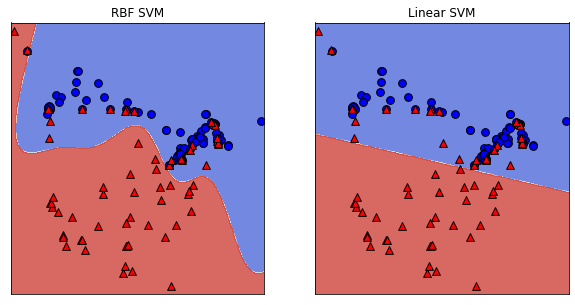

In [125]:
models = {
    "RBF SVM": SVC(gamma=0.01), # default SVM is RBF SVM
    "Linear SVM": SVC(kernel='linear')
}

plt.figure(figsize=(10, 5))
i = 0
for name, model in models.items():    
    plt.subplot(1, 2, i + 1)
    model.fit(X_train, y_train)
    scores = cross_validate(model, X_train, y_train)
    print('%s mean cv score: %s' %(name, pd.DataFrame(scores).mean()['test_score']))
    plot_classifier(X_train, y_train, model, ax=plt.gca())
    plt.title(name);
    i += 1

#### 1). `predict`, `coef` and `intercept`

> Note that the coefficients and intercept are slightly different for logistic regression. 
- This is because the `fit` for linear SVM and logistic regression are different. 

In [127]:
linear_svc = SVC(kernel='linear')
linear_svc.fit(X_train, y_train)
print("Model weights: %s"%(linear_svc.coef_))
print("Model intercept: %s"%(linear_svc.intercept_))

Model weights: [[-0.0195598  -0.23640124]]
Model intercept: [8.22811601]


In [128]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s"%(lr.coef_))
print("Model intercept: %s"%(lr.intercept_))

Model weights: [[-0.04108149 -0.33683126]]
Model intercept: [10.8869838]


## 3. `LinearRegression` - `Ridge`

#### Limitations of linear classifiers 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.


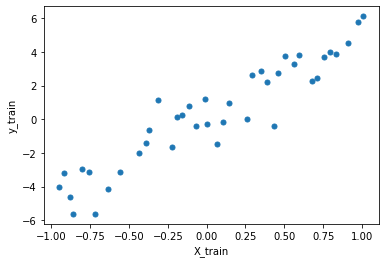

In [131]:
n = 50
X = np.linspace(-1,1,n)+np.random.randn(n)*0.01
X = X[:,None]
y = np.random.randn(n,1) + X*5
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
grid = np.linspace(min(X_train),max(X_train),1000)

plt.plot(X_train, y_train, '.', markersize=10);
plt.xlabel('X_train');

plt.ylabel('y_train');

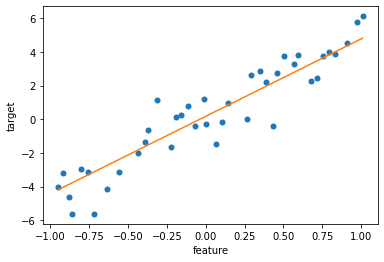

In [133]:
from sklearn.linear_model import Ridge
r = Ridge()
r.fit(X_train, y_train)


plt.plot(X_train,y_train,'.',markersize=10);
plt.plot(grid, r.predict(grid));
plt.xlabel("feature")
plt.ylabel("target");

## 4. Multi-class, meta-strategies

### Multi-class strategies

- Two common strategies
    - One-vs-rest
    - One-vs-one

By default LogisticRegression uses one-vs-rest strategy to deal with multi-class


### When do we use  `OneVsRestClassifier` and ``OneVsOneClassifier``

- It's not that likely for you to need `OneVsRestClassifier` or `OneVsOneClassifier` because most of the methods you'll use will have native multi-class support. 
- However, it's good to know in case you ever need to extend a binary classifier (perhaps one you've implemented on your own).

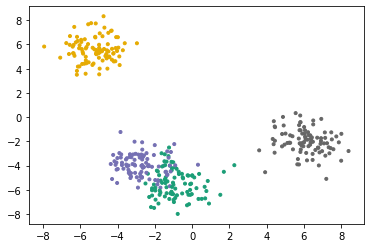

In [134]:
from sklearn.datasets import make_blobs

# generate blobs with fixed random generator
X, y = make_blobs(n_samples=500, centers=4, random_state=300)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(*X_train.T, c=y_train, marker=".", cmap="Dark2");

#### 1). LogisticRegression - one-vs-rest

> Logistic regression seems to be working without problem on it.

### Uses "one-vs-rest" scheme (also known as one-vs-all)
  - turns $k$-class classification into $k$ binary classification problems
  - builds $k$ binary classifiers; for each classifier, the class is fitted against all the other classes
  - each one gives a probability of that class assuming it to be "positive" using the sigmoid function
  - normalize these values across all the classes
  - the class with the maximum value is the prediction 
  - you can do this yourself for any binary classifier using the meta-classifier [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

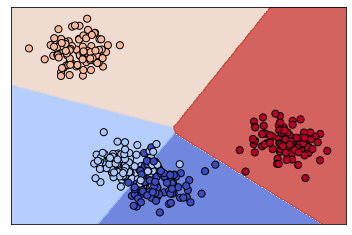

In [135]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
plot_classifier(X_train, y_train, lr);

> "one-vs-rest" scheme

you can do this yourself for any binary classifier using the meta-classifier OneVsRestClassifier

<AxesSubplot:>

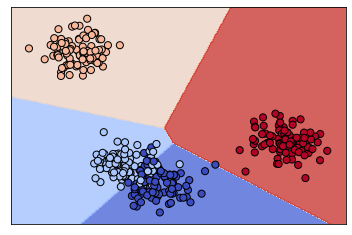

In [136]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X_train, y_train)
plot_classifier(X_train, y_train, ovr)

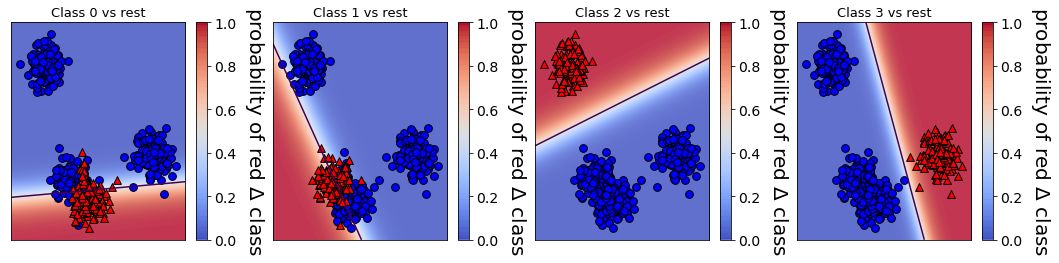

In [137]:
# Here's how one-vs-rest works:
def one_vs_rest_plots(model_class, X, y):
    plt.figure(figsize=(18, 4))
    classes = np.unique(y)
    k = len(classes)
    for i, c in enumerate(classes):
        plt.subplot(1, k, i + 1)

        y_binary = y == c
        model = model_class()
        model.fit(X, y_binary)
        plot_classifier(X, y_binary, model, ax=plt.gca(), proba=True)
        plt.title("Class %d vs rest" % c, fontsize=13)


one_vs_rest_plots(LogisticRegression, X, y)

#### 2). Linear SVMs - one-vs-one


### "one-vs-one"
- A multi-class linear SVM looks similar, though, by default, it's done with "one-vs-one" instead of one-vs-rest
  - This requires fitting $O(k^2)$ classifiers, where $k$ is number of classes, which is slow.
  - To be precise, it requires fitting $k \times (k − 1)/2$ classifiers; each class gets paired up with all other classes except itself and we divide by 2 because class 1 vs. class 2 classifier is the same as class 2 vs. class 1 classifier.
  - How many models need to be trained for the ImageNet challenge (which has 1000 classes)?
- Note that `SVC` multiclass mode is implemented using one-vs-one scheme whereas `LinearSVC` uses one-vs-rest scheme. 
- That said, we can use the OneVsRestClassifier wrapper to implement one-vs-rest with SVC.
- [Here](https://scikit-learn.org/stable/modules/multiclass.html) you will find summary of how `scikit-learn` handles multi-class classification for different classifiers. 

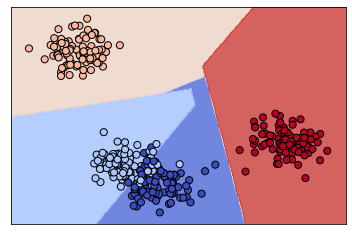

In [139]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
plot_classifier(X_train, y_train, svm);

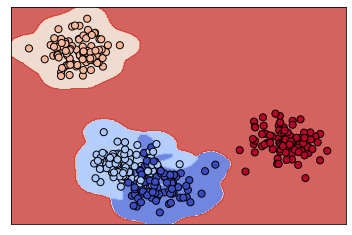

In [140]:
# Here's a multi-class nonlinear SVM:
svm_multi = SVC(kernel="rbf", gamma=2, C=100)
svm_multi.fit(X_train, y_train)
plot_classifier(X_train, y_train, svm_multi);

## 5. Questions


---

### Summary
Classifier |      Strengths | Weaknesses | Key hyperparameters |
:-----------|      :------------|:------------|:---------------------|
decision tree | Interpretable; validatable; $\mathcal{O}(\log n)$ prediction cost | Unstable with respect to data; prone to overfitting: sensitive to `max-depth`. | `max_depth` |
$k$-NN | Minimal training; few moving parts. Runs somewhere between $\mathcal{O}(d \log n)$ and $\mathcal{O}(dn)$ | Sensitive to feature scaling, choice of $k$; distances "don't make sense" in high dimensions | `k` |
SVM | prediction cost $\propto$ # support vectors; strong predictive power *via* kernel trick  | Slow. Training is $\mathcal{\Omega}(dn^2)$ | `C`, `gamma` |
naive Bayes | Fast. Natural probabilistic interpretation. | Conditional independence often unrealistic. | `alpha` |
logistic regression | Outputs have a nice probabilistic interpretation; training time complexicity is $\mathcal{O}(dn)$ | doesn't work well when the decision boundaries are non-linear | `C` |

---
### Short Answers

#### 1). Would it be hard to get most informative features using other classifiers such as SVMs with RBF kernel, naive Bayes, or decision trees? Why or why not?
- RBF SVMs and $k$-NNs $\rightarrow$ It is hard to get feature importances for RBF SVM because it's an analogy-based algorithm based on distances between examples, where all features are given similar importance. 
- naive Bayes $\rightarrow$ The conditional probabilities in naive Bayes can give us a sense of feature importances. You can interpret naive Bayes as a linear model by considering log probabilities. Accordingly, similar to linear models, `sklearn`'s `MultinomialNB` has `coef_` attribute, which can be use to interpret how important is each feature.    
- Decision trees $\rightarrow$ The decision tree algorithm is based on finding most important features using criteria such as information gain or Gini importance, in `sklearn`. Accordingly, `sklearn`'s `DecisionTreeClassifier` has a `feature_importances_` attribute to get this information. 


#### 2). Choosing a classifier: Logistic regression vs. Naive Bayes

- Naive Bayes has overly strong conditional independence assumptions. So it is **not great when features are correlated**. 
    - If two features are strongly correlated, naive Bayes will be  overestimating the evidence of that feature.
- Logistic regression is much **more robust to correlated features**
    - If two features are correlated, regression will assign part of the weight to one and part
to another.     


#### 3). Can logistic regression work with categorical features?
- No. We need numerically encoded features for logistic regression.


#### 4). Suppose you want to train one-vs-rest classifier on a 1000-class problem. Suppose the training time for each binary classifier is $t$. How much time it would take to train the one-vs-rest classifier? 
1. $1000 \times t$ (correct answer)
2. $1000^2 \times t$
3. $((1000)(999)/2) \times t$


#### 5). Name two popular methods for applying a binary classifier to a multi-class classification problem. Give a disadvantage of using each method.
**Answer**
- OneVsOne disadvantage: Slow because it requires fitting $O(k^2)$ classifiers, where k is the number of classes. (To be precise, it requires fitting $k \times (k − 1)/2$ classifiers; each class gets paired up with all other classes except itself and we divide by 2 because class 1 vs. class 2 classifier is the same as class 2 vs. class 1 classifier.)

- OneVsRest disadvantage: unbalanced class distributions when training each classifier (especially when the number of classes is large).

---

### True False questions

#### 1). The coefficients of a linear classifier have the following interpretation: if coefficient $j$ is large, that means a change in feature $j$ has a large impact on the prediction.
**Answer**
> False for two reasons. 
- First, the interpretation is associated with the magnitude of the coefficient. For example, consider coefficients 0.2 and -3. The former is larger then the latter but the latter would have a larger impact on the prediction. 
- Second, it also depends upon the scale of the feature values. Suppose you have two features: $x_1$ which is either 0 or 1 and $x_2$, which is either 0 or 1000 and suppose $w_1 = 0.5 > w_2 =0.1$. In this case, $x_2$ would still have a larger impact on the prediction, as it's scale is much larger. 

#### 2). For linear classifiers, the decision boundary (the boundary dividing the two classes) is a $d-1$-dimensional hyperplane, where $d$ is the number of features.
**Answer**
> True. 

- For example, in our 2-dimensional cities dataset, the decision boundary is a one-dimensional line. 

#### 3). When you have correlated features, logistic regression might be a better choice than naive Bayes.
**Answer**
> True. 

Naive Bayes **assumes conditional independence of features** given the target value and it's not a particularly thoughtful choice when you have correlated features. Logistic regression is a bit more robust to correlated features compared to naive Bayes because it can adjust the coefficients for the features so that only one of the correlated features is considered. 

#### 4). Feature scaling is a good idea for logistic regression.
**Answer**
> True. 

It's a good idea to carry out feature scaling for logistic regression for feature interpretation. For instance, suppose you have two features $x_1$ which, is either 0 or 1, and $x_2$, which is either 0 or 1000 and if $w_1$ and $w_2$ are equal, the latter is going to have a bigger impact on the prediction because the feature scale is larger. So with different feature scales, it's hard to interpret feature importance simply based on the coefficients. The easiest way to compensate for this is simply to scale features before training.

#### 5). Feature scaling can improve the performance of logistic regression.
**Answer**
> False. 

The performance of logistic regression did not improve with data scaling. Why not, particularly when we saw that k-Nearest Neigbours performance improved substantially with scaling? The reason is that, if there predictor variables with large ranges that do not effect the target variable, a regression algorithm will make the corresponding coefficients ai small so that they do not effect predictions so much. K-nearest neighbours does not have such an inbuilt strategy and so we very much needed to scale the data.

The performance of logistic regression did not improve with data scaling.
The reason is that, if their predictor variables with large ranges that do not affect the target variable, a regression algorithm will make the corresponding coefficients ai small so that they do not affect predictions so much.